<a href="https://colab.research.google.com/github/jinglescode/generative-adversarial-networks/blob/main/tutorials/04%20Training%20GAN/Train%20Basic%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this notebook

This notebook contains code for training a generative adversarial network that learns to generate hand written digits. 

[Read more](https://github.com/jinglescode/generative-adversarial-networks/tree/main/tutorials/04%20Training%20GAN)



We begin by importing libraries, create helper functions and define parameters.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm


def generate_and_visualize(generator_net):
    random_noise = get_noise(10, dim_noise, device)
    generated_samples = generator_net(random_noise)
    show_images(generated_samples)
    

def show_images(image_tensor, num_images=10, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [9]:
n_epochs = 100 # number of iterations
dim_noise = 64 # size of the noise vector
batch_size = 128 # number of samples in one pass, generally restricted by the memory
lr = 0.00001 # learning rate
device = 'cuda' # cpu or cuda

# Components


## Discriminator

The discriminator is a classifier that aims to capture the conditional probability P(y|x). It learns to model the probability of an example being real or fake given that set of input features. The output probabilities from the discriminator are classification labels.

[Read more](https://github.com/jinglescode/generative-adversarial-networks/tree/main/tutorials/02%20Discriminator)

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Parameters:
        in_dim: int, default: 784
          the dimension of the input (MNIST images are 28x28, so 784 so is the default)
        hidden_dim: int, default: 128
          the inner dimension
        out_dim: int, default: 1
          default 1 because we returns a 1-dimension tensor representing fake/real
    '''
    def __init__(self, in_dim=784, hidden_dim=128, out_dim=1):
        super(Discriminator, self).__init__()

        dims = [hidden_dim*4, hidden_dim*2, hidden_dim]

        self.layers = nn.Sequential(
            self.discriminator_block(in_dim, dims[0]),
            self.discriminator_block(dims[0], dims[1]),
            self.discriminator_block(dims[1], dims[2]),
            nn.Linear(dims[2], out_dim)
        )

    def forward(self, x):
        return self.layers(x)
    
    def discriminator_block(self, input_dim, output_dim):
        '''
        A discriminator neural network layer, with a linear transformation 
        followed by an nn.LeakyReLU activation with negative slope of 0.2 
        '''
        return nn.Sequential(
          nn.Linear(input_dim, output_dim),
          nn.LeakyReLU(negative_slope=0.2)
      )


## Generator

The goal of generative models is to learn to produce realistic samples to fool the discriminator, so the generative neural network is trained to maximize the final classification error. Like an artist that can paint pictures that look like actual paintings or sceneries, or generate pictures of cats with different variations, that the discriminator could not tell real from the generated data.

[Read more](https://github.com/jinglescode/generative-adversarial-networks/tree/main/tutorials/03%20Generator)

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Parameters:
        dim_noise: int, default: 10
          the dimension of the noise vector
        in_dim: int, default: 784
          the dimension of the images, fitted for the dataset used
          (MNIST images are 28x28, so 784 so is the default)
        hidden_dim: int, default: 128
          the inner dimension size
    '''
    def __init__(self, dim_noise=10, in_dim=784, hidden_dim=128):
        super(Generator, self).__init__()

        dims = [hidden_dim, hidden_dim*2, hidden_dim*4, hidden_dim*8]

        self.gen = nn.Sequential(
            self.generator_block(dim_noise, dims[0]),
            self.generator_block(dims[0], dims[1]),
            self.generator_block(dims[1], dims[2]),
            self.generator_block(dims[2], dims[3]),
            nn.Linear(dims[3], in_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)
    
    def generator_block(self, input_dim, output_dim):
        '''
        A generator neural network layer, with a linear transformation, batchnorm and relu.
        '''
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(inplace=True),
        )


## Loss Functions for training GAN

- get_noise - generate random noise vectors for generator's input
- get_discriminator_loss - given generated and real samples, discriminator predict and get loss
- get_generator_loss - generator generates and get loss
- generate_and_visualize - generator generate samples and call `show_images`
- show_images - display generated samples

[Read more](https://github.com/jinglescode/generative-adversarial-networks/tree/main/tutorials/04%20Training%20GAN)

In [5]:
def get_noise(n_samples, dim_noise, device='cpu'):
    '''
    Create noise vectors for generator
    Parameters:
        n_samples: int
            number of samples to generate
        dim_noise: int
            dimension of noise vector
        device: string
            device, cpu or cuda
    '''
    return torch.randn(n_samples, dim_noise).to(device)
    

def get_discriminator_loss(generator, discriminator, criterion, real_samples, n_samples, dim_noise, device):
    '''
    Discriminator predict and get loss
    Parameters:
        generator: 
            generator network
        discriminator: 
            discriminator network
        criterion: 
            loss function, likely `nn.BCEWithLogitsLoss()`
        real_samples: 
            samples from training dataset
        n_samples: int
            number of samples to generate
        dim_noise: int
            dimension of noise vector
        device: string
            device, cpu or cuda
    Returns:
        discriminator_loss: 
            loss scalar
    '''
    
    random_noise = get_noise(n_samples, dim_noise, device=device)
    generated_samples = generator(random_noise)
    discriminator_fake_pred = discriminator(generated_samples.detach())
    discriminator_fake_loss = criterion(discriminator_fake_pred, torch.zeros_like(discriminator_fake_pred))
    discriminator_real_pred = discriminator(real_samples)
    discriminator_real_loss = criterion(discriminator_real_pred, torch.ones_like(discriminator_real_pred))
    discriminator_loss = (discriminator_fake_loss + discriminator_real_loss) / 2

    return discriminator_loss


def get_generator_loss(generator, discriminator, criterion, n_samples, dim_noise, device):
    '''
    Generator generates and get discriminator's loss
    Parameters:
        generator: 
            generator network
        discriminator: 
            discriminator network
        criterion: 
            loss function, likely `nn.BCEWithLogitsLoss()`
        n_samples: int
            number of samples to generate
        dim_noise: int
            dimension of noise vector
        device: string
            device, cpu or cuda
    Returns:
        generator_loss: 
            loss scalar
    '''
    
    random_noise = get_noise(n_samples, dim_noise, device=device)
    generated_samples = generator(random_noise)
    discriminator_fake_pred = discriminator(generated_samples)
    generator_loss = criterion(discriminator_fake_pred, torch.ones_like(discriminator_fake_pred))
    
    return generator_loss



## Load data and initialize

Load [MNIST](http://yann.lecun.com/exdb/mnist/) dataset from `torchvision.datasets`. It contains images of hand-written digits in 28x28 pixels.

Loss function is [binary cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) because the prediction is either `real` or `fake`.

We train the networks with the [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [6]:
# data
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

# loss function
criterion = nn.BCEWithLogitsLoss() 

# generator 
generator_net = Generator(dim_noise=dim_noise).to(device)
generator_optim = torch.optim.Adam(generator_net.parameters(), lr=lr)

# discriminator
discriminator_net = Discriminator().to(device) 
discriminator_optim = torch.optim.Adam(discriminator_net.parameters(), lr=lr)

# Training GAN


Epoch 1: Generator loss: 1.2810600039958946, discriminator loss: 0.3977767187952991



Epoch 2: Generator loss: 1.54782809495926, discriminator loss: 0.2927051236033442



Epoch 3: Generator loss: 1.807475224971772, discriminator loss: 0.17476049277186392



Epoch 4: Generator loss: 1.7160287485122683, discriminator loss: 0.1720640426874161



Epoch 5: Generator loss: 1.5857663357257865, discriminator loss: 0.1929260016977786



Epoch 6: Generator loss: 1.8287121109962468, discriminator loss: 0.1475705189257861



Epoch 7: Generator loss: 2.0932089221477512, discriminator loss: 0.12407076385617254



Epoch 8: Generator loss: 2.457569557666776, discriminator loss: 0.11442195260524746



Epoch 9: Generator loss: 2.7064867596626287, discriminator loss: 0.11012147499620911



Epoch 10: Generator loss: 3.0096504321098325, discriminator loss: 0.09300719106197361


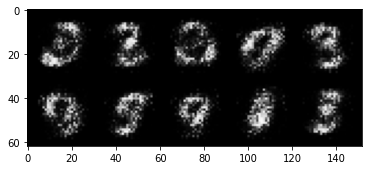


Epoch 11: Generator loss: 3.1909972381591802, discriminator loss: 0.08465903520584106



Epoch 12: Generator loss: 3.351298644542696, discriminator loss: 0.07984423599392185



Epoch 13: Generator loss: 3.3879184017181414, discriminator loss: 0.07080134948343035



Epoch 14: Generator loss: 3.500232713699342, discriminator loss: 0.05655757052451371



Epoch 15: Generator loss: 3.7175124049186676, discriminator loss: 0.04834460170939565



Epoch 16: Generator loss: 3.8130568962097153, discriminator loss: 0.05165077328309412



Epoch 17: Generator loss: 3.7620509867668126, discriminator loss: 0.0630463604032993



Epoch 18: Generator loss: 3.7264092054367097, discriminator loss: 0.053829719889908985



Epoch 19: Generator loss: 3.8538657035827617, discriminator loss: 0.04902119385823602



Epoch 20: Generator loss: 3.9359711980819685, discriminator loss: 0.05174772644415494


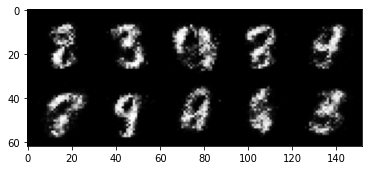


Epoch 21: Generator loss: 3.692351419448855, discriminator loss: 0.06409567819535732



Epoch 22: Generator loss: 3.6494957070350664, discriminator loss: 0.07115286288410426



Epoch 23: Generator loss: 3.6996074695587193, discriminator loss: 0.06892843239009379



Epoch 24: Generator loss: 3.778825665473941, discriminator loss: 0.06970621110498909



Epoch 25: Generator loss: 3.8553684301376347, discriminator loss: 0.062170778587460535



Epoch 26: Generator loss: 3.778673141479491, discriminator loss: 0.067114931114018



Epoch 27: Generator loss: 3.7822600669860806, discriminator loss: 0.07464035161584619



Epoch 28: Generator loss: 3.863679203510283, discriminator loss: 0.07470573233067987



Epoch 29: Generator loss: 3.6886837067604077, discriminator loss: 0.07772320733964448



Epoch 30: Generator loss: 3.6948870840072647, discriminator loss: 0.08203615202009673


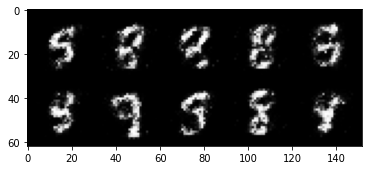


Epoch 31: Generator loss: 3.526640382289884, discriminator loss: 0.10734586669504635



Epoch 32: Generator loss: 3.4117841076850866, discriminator loss: 0.11465570391714572



Epoch 33: Generator loss: 3.4433016252517734, discriminator loss: 0.1018982143774628



Epoch 34: Generator loss: 3.3952951250076278, discriminator loss: 0.11473899906128651



Epoch 35: Generator loss: 3.3155500159263607, discriminator loss: 0.11342742908000952



Epoch 36: Generator loss: 3.206401024341585, discriminator loss: 0.12205178561806669



Epoch 37: Generator loss: 3.2551347985267642, discriminator loss: 0.10918934440612792



Epoch 38: Generator loss: 3.156300654411315, discriminator loss: 0.11505531286448245



Epoch 39: Generator loss: 3.191676961898802, discriminator loss: 0.11207210778445012



Epoch 40: Generator loss: 3.1872646007537795, discriminator loss: 0.11209045536816109


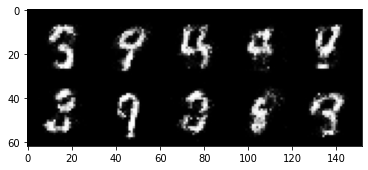


Epoch 41: Generator loss: 3.181251263618467, discriminator loss: 0.11331480125337831



Epoch 42: Generator loss: 3.231162899971007, discriminator loss: 0.12175650598108759



Epoch 43: Generator loss: 3.2311071033477767, discriminator loss: 0.11872916729748245



Epoch 44: Generator loss: 2.992221487045286, discriminator loss: 0.14450363010168069



Epoch 45: Generator loss: 2.973484937667848, discriminator loss: 0.13728442588448508



Epoch 46: Generator loss: 2.9628288331031807, discriminator loss: 0.14544510890543466



Epoch 47: Generator loss: 2.8649312758445746, discriminator loss: 0.15708981497585764



Epoch 48: Generator loss: 2.77561882829666, discriminator loss: 0.16447427526116382



Epoch 49: Generator loss: 2.9227659301757836, discriminator loss: 0.14949734325706962



Epoch 50: Generator loss: 2.8476941189765936, discriminator loss: 0.16781850318610678


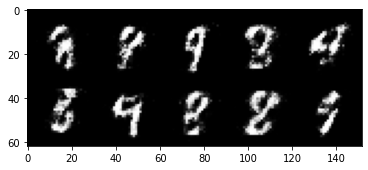


Epoch 51: Generator loss: 2.7805860042571977, discriminator loss: 0.1806360062509775



Epoch 52: Generator loss: 2.6277618184089673, discriminator loss: 0.19591490136086925



Epoch 53: Generator loss: 2.761082591533661, discriminator loss: 0.18044881728291493



Epoch 54: Generator loss: 2.7742610006332407, discriminator loss: 0.17500865620374678



Epoch 55: Generator loss: 2.6808984632492048, discriminator loss: 0.18978211143612864



Epoch 56: Generator loss: 2.611803809165953, discriminator loss: 0.1891340977251528



Epoch 57: Generator loss: 2.541364115715026, discriminator loss: 0.20122740864753744



Epoch 58: Generator loss: 2.480014366626739, discriminator loss: 0.213190221041441



Epoch 59: Generator loss: 2.408197800636291, discriminator loss: 0.2201180578321218



Epoch 60: Generator loss: 2.4256217780113207, discriminator loss: 0.24025059279799474


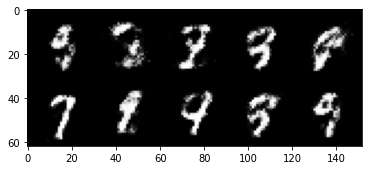


Epoch 61: Generator loss: 2.396168382167816, discriminator loss: 0.23315075549483308



Epoch 62: Generator loss: 2.3963074603080767, discriminator loss: 0.22844633367657655



Epoch 63: Generator loss: 2.361381981372832, discriminator loss: 0.23383184367418294



Epoch 64: Generator loss: 2.3224510142803187, discriminator loss: 0.2451076272130013



Epoch 65: Generator loss: 2.4021243925094597, discriminator loss: 0.21928173193335543



Epoch 66: Generator loss: 2.419842340230943, discriminator loss: 0.21412035927176476



Epoch 67: Generator loss: 2.3802110829353316, discriminator loss: 0.22993645837903043



Epoch 68: Generator loss: 2.3767381210327163, discriminator loss: 0.22637885677814484



Epoch 69: Generator loss: 2.370427829265594, discriminator loss: 0.2253003262281417



Epoch 70: Generator loss: 2.410520850658413, discriminator loss: 0.21233719310164462


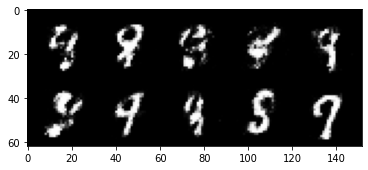


Epoch 71: Generator loss: 2.406064735412598, discriminator loss: 0.22067595174908622



Epoch 72: Generator loss: 2.4546551737785323, discriminator loss: 0.21933263924717916



Epoch 73: Generator loss: 2.2681274578571324, discriminator loss: 0.24050473076105128



Epoch 74: Generator loss: 2.2792869858741738, discriminator loss: 0.23757345205545422



Epoch 75: Generator loss: 2.259017477512359, discriminator loss: 0.2429792605042455



Epoch 76: Generator loss: 2.481775827407839, discriminator loss: 0.2073916522860529



Epoch 77: Generator loss: 2.2220921487808227, discriminator loss: 0.247139694750309



Epoch 78: Generator loss: 2.1884723949432368, discriminator loss: 0.2512799414992332



Epoch 79: Generator loss: 2.2192487843036655, discriminator loss: 0.24827473872900022



Epoch 80: Generator loss: 2.1999820268154147, discriminator loss: 0.23614807498455048


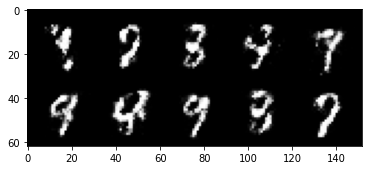


Epoch 81: Generator loss: 2.2492735857963595, discriminator loss: 0.23483272719383247



Epoch 82: Generator loss: 2.1787190098762514, discriminator loss: 0.25143344688415536



Epoch 83: Generator loss: 2.1395591056346888, discriminator loss: 0.25257343655824654



Epoch 84: Generator loss: 2.1112489891052233, discriminator loss: 0.2595865078568457



Epoch 85: Generator loss: 2.08540887475014, discriminator loss: 0.2769423931539059



Epoch 86: Generator loss: 2.0756202559471144, discriminator loss: 0.2707674917876721



Epoch 87: Generator loss: 2.015868325710296, discriminator loss: 0.2789908293485642



Epoch 88: Generator loss: 2.125667993545531, discriminator loss: 0.25510864141583445



Epoch 89: Generator loss: 2.002358829736708, discriminator loss: 0.2906112787723537



Epoch 90: Generator loss: 2.0164287781715395, discriminator loss: 0.268293162077665


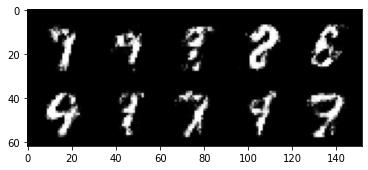


Epoch 91: Generator loss: 2.1216241073608413, discriminator loss: 0.2586476978957652



Epoch 92: Generator loss: 2.0298945772647876, discriminator loss: 0.27080080962181075



Epoch 93: Generator loss: 1.9877258260250088, discriminator loss: 0.27871660175919544



Epoch 94: Generator loss: 2.022166890382766, discriminator loss: 0.27711453106999406



Epoch 95: Generator loss: 2.0233312065601345, discriminator loss: 0.2846469615995883



Epoch 96: Generator loss: 2.0147632918357856, discriminator loss: 0.2849108580350875



Epoch 97: Generator loss: 1.977455605745315, discriminator loss: 0.27974169832468054



Epoch 98: Generator loss: 1.999356290817258, discriminator loss: 0.26851254680752734



Epoch 99: Generator loss: 2.0099079141616816, discriminator loss: 0.27614317825436585



Epoch 100: Generator loss: 1.9634699909687032, discriminator loss: 0.2784235606789588


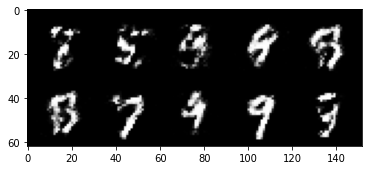

In [7]:
mean_generator_loss = 0
mean_discriminator_loss = 0
visualize_every_epoch = 10

for epoch in range(n_epochs):
    for real_samples, _ in tqdm(dataloader):
        batch_size = len(real_samples)

        real_samples = real_samples.view(batch_size, -1).to(device)

        # train discriminator
        discriminator_optim.zero_grad()
        discriminator_loss = get_discriminator_loss(generator_net, discriminator_net, criterion, real_samples, batch_size, dim_noise, device)
        discriminator_loss.backward(retain_graph=True)
        discriminator_optim.step()
        mean_discriminator_loss += discriminator_loss.item() / display_step

        # train generator
        generator_optim.zero_grad()
        generator_loss = get_generator_loss(generator_net, discriminator_net, criterion, batch_size, dim_noise, device)
        generator_loss.backward()
        generator_optim.step()
        mean_generator_loss += generator_loss.item() / display_step

    print(f"Epoch {epoch+1}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
    mean_generator_loss = 0
    mean_discriminator_loss = 0

    # generate and visualize
    if (epoch+1)%visualize_every_epoch == 0:
        generate_and_visualize(generator_net)

# Generate samples

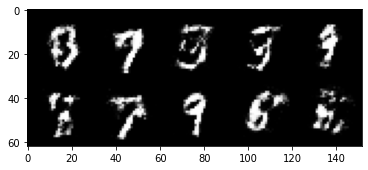

In [8]:
generate_and_visualize(generator_net)